<a href="https://colab.research.google.com/github/aditiiilaturkar/911Interactions/blob/main/KNN_with_Cosine_address_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import nltk
nltk.download('stopwords') # download stopwords if you haven't already
from nltk.corpus import stopwords

# Load CSV file into a dataframe
df = pd.read_excel('part3.xlsx')

# Drop rows with missing values in the 'AddressExtracted' column
df.dropna(subset=['AddressExtracted'], inplace=True)

# Define a regular expression pattern to match dates
date_pattern = r'\d{1,2}[-/.]\d{1,2}[-/.]\d{2,4}|\d{4}[-/.]\d{1,2}[-/.]\d{1,2}'

# Remove rows with dates in the 'AddressExtracted' column
df = df[~df['AddressExtracted'].str.contains(date_pattern)]

# Define a function to remove stop words and greeting words
def remove_stopwords(text):
    words = text.split()
    stop_words = set(stopwords.words('english'))
    # add greetings words to the set of stop words
    stop_words.update(['hello', 'hi', 'okay', 'ok', 'knife', '911', 'emergency', 'pain', 'covid', 'daddy', '', 'maam', 'call', 'Tina', 'steve', 'cancel', 'traffic'])
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

# Apply the function to the 'AddressExtracted' column
df['AddressExtracted'] = df['AddressExtracted'].apply(remove_stopwords)

# Save the updated dataframe to a new CSV file
df.to_csv('filtered_address_extracted.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Load the CSV files
df1 = pd.read_csv('dev_dispatch_incidents.csv')
df2 = pd.read_csv('filtered_address_extracted.csv')

# Remove rows with missing or blank data
df1.dropna(subset=['address'], inplace=True)
df1 = df1[df1['address'] != '']
df2.dropna(subset=['AddressExtracted'], inplace=True)
df2 = df2[df2['AddressExtracted'] != '']

# Reset the index of the df2 DataFrame
df2.reset_index(drop=True, inplace=True)

# Convert the AddressExtracted column in the second file to a numeric vector
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df2['AddressExtracted'])
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

# Initialize the KNN model
k = 3
knn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine')

# Train the KNN model on the numeric vectors
knn.fit(X)

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['address', 'Neighbour1',  'Neighbour2', 'Neighbour3',  'maxSimilarityScore', 'AddressExtracted'])

# Iterate over each row of the first file
for index, row in df1.iterrows():
    # Convert the address to a numeric vector
    address = row['address']
    address_vector = vectorizer.transform([address])
    address_vector = scaler.transform(address_vector)

    # Find the k nearest neighbors of the address
    distances, indices = knn.kneighbors(address_vector)

    # Get the nearest neighbors, their nature, and similarity scores
    neighbors = []
    nature = []
    similarity_scores = []
    for i, distance in zip(indices[0], distances[0]):
        neighbors.append(df2.loc[i, 'AddressExtracted'])
        # nature.append(df2.loc[i, 'nature'])
        similarity_scores.append(1 - distance)

    # Find the neighbor with the maximum similarity score
    max_similarity_score = max(similarity_scores)
    max_similarity_score_index = similarity_scores.index(max_similarity_score)

    # Add the results to the DataFrame
    results_df.loc[index] = [address, neighbors[0],  neighbors[1], neighbors[2],  max_similarity_score, neighbors[max_similarity_score_index]]

# Save the results to a CSV file
results_df.to_csv('KNN_Cosine_results.csv', index=False)


<ipython-input-3-8ddbe4c2ec6e>:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', linewidth=1, fill=True) for i in range(len(bins))]


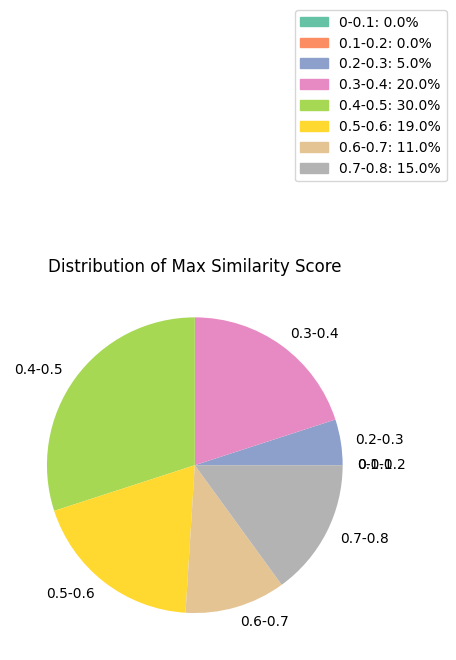

In [3]:
import matplotlib.pyplot as plt

# Calculate the frequency and percentage of each similarity score bin
bins = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8']
freq = [0] * len(bins)
total_rows = len(results_df)

for score in results_df['maxSimilarityScore']:
    if score < 0.1:
        freq[0] += 1
    elif score < 0.2:
        freq[1] += 1
    elif score < 0.3:
        freq[2] += 1
    elif score < 0.4:
        freq[3] += 1
    elif score < 0.5:
        freq[4] += 1
    elif score < 0.6:
        freq[5] += 1
    elif score < 0.7:
        freq[6] += 1
    else:
        freq[7] += 1

percent = [(f/total_rows)*100 for f in freq]

# Define colors for each bin
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

# Create the pie chart
plt.pie(percent, labels=[bins[i] for i in range(len(bins))], colors=colors, autopct='')

# Create custom legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', linewidth=1, fill=True) for i in range(len(bins))]
labels = [f"{bins[i]}: {percent[i]:.1f}%" for i in range(len(bins))]
plt.legend(handles, labels, bbox_to_anchor=(1.2, 1.5), loc='center right')

plt.title('Distribution of Max Similarity Score')
plt.show()
